# 4. Scattering calculations

This example demonstrates the basic principles of performing scattering calcualtions with ARTS. Populations of particles that scatter radiation are referred to as *scattering species*. Each scattering species defines a mapping from one or several fields of *scattering species properties* to *scattering properties* which form the input to the actual scattering calculation.

## Set up a 1D atmosphere

In [1]:
import numpy as np
import pyarts

ws = pyarts.Workspace()
ws.surface_fieldSetPlanetEllipsoid(option="Earth")
ws.surface_field[pyarts.arts.SurfaceKey("t")] = 295.0
ws.atmospheric_fieldRead(
    toa=100e3, basename="planets/Earth/afgl/tropical/", missing_is_zero=1
)
ws.atmospheric_fieldIGRF(time="2000-03-11 14:39:37")

## Add a field of scattering species properties

For this example, we will use scatterers with a Henyey-Greenstein phase function to represent ice particles. We will use two *scattering species properties* to represent the scattering species *ice*: The extinction and the single-scattering albed (SSA). The ice extinction and SSA thus become atmospheric fields. Below we define scattering-species-property object that identify these fields.

In [2]:
ice_extinction = pyarts.arts.ScatteringSpeciesProperty("ice", pyarts.arts.ParticulateProperty("Extinction"))
ice_ssa = pyarts.arts.ScatteringSpeciesProperty("ice", pyarts.arts.ParticulateProperty("SingleScatteringAlbedo"))

We then define a GriddedField3 representing the ice extinction and single-scattering albedo and add it to ``atm_field`` of the workspace.

In [3]:
grids = ws.atmospheric_field["t"].data.grids
z = grids[0]
ice_extinction_profile = np.zeros_like(z)
ice_extinction_profile[(z > 10e3) * (z < 15e3)] = 1.0
ice_extinction_profile = pyarts.arts.GriddedField3(data=ice_extinction_profile[..., None, None], grids=grids)
ws.atmospheric_field[ice_extinction] = ice_extinction_profile

ice_ssa_profile = np.zeros_like(z)
ice_ssa_profile[(z > 10e3) * (z < 15e3)] = 1.0
ice_ssa_profile = pyarts.arts.GriddedField3(data=ice_ssa_profile[..., None, None], grids=grids)
ws.atmospheric_field[ice_ssa] = ice_ssa_profile

## Create the scattering species

In [4]:
from pyarts.arts import HenyeyGreensteinScatterer

hg = HenyeyGreensteinScatterer(ice_extinction, ice_ssa, 0.5)

## Extracting scattering properties

We can now extract bulkd scattering properties from the scattering species.

In [15]:
atm_pt = ws.atmospheric_field.at(11e3, 0.0, 0.0)
bsp = hg.get_bulk_scattering_properties_tro_spectral(atm_pt, 32)
pm_spectral = bsp.phase_matrix

In [16]:
za_scat_grid = pm_spectral.to_gridded().get_za_scat_grid()
bsp = hg.get_bulk_scattering_properties_aro_spectral(atm_pt, za_scat_grid)
pm_gridded = bsp.phase_matrix

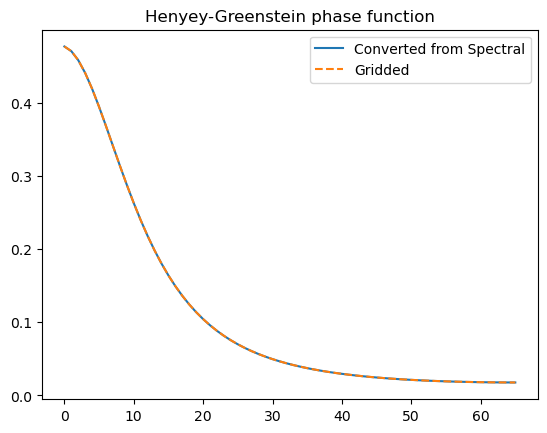

In [17]:
import matplotlib.pyplot as plt
plt.plot(pm_spectral.to_gridded().flatten(), label="Converted from Spectral")
plt.plot(pm_gridded.flatten(), ls="--", label="Gridded")
plt.title("Henyey-Greenstein phase function")
plt.legend()